In [1]:
from dataset import Dataset
from feature_extractor import FeatureExtractor
from monitors_internals import MahalanobisMonitor, GaussianMixtureMonitor, OutsideTheBoxMonitor, MaxSoftmaxProbabilityMonitor,\
                    MaxLogitMonitor, EnergyMonitor, ReActMonitor
from monitors_input import SHINE_monitor
from evaluation import Evaluator

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

In [2]:
batch_size = 10

model = "resnet"
# model = "densenet"

layers_ids = [2, 5, 8, 12, 15, 19, 22, 26, 29, 32]
# layers_ids = [9, 19, 29, 40, 50, 60, 69, 79, 89, 98]

id_dataset = "cifar10"

ood_dataset = "svhn"

additional_transform = None#"pixelization"
adversarial_attack = None#"fgsm"

In [3]:
dataset_train = Dataset(id_dataset, "train", model, batch_size=batch_size)
dataset_test = Dataset(id_dataset, "test", model, batch_size=batch_size)
dataset_ood = Dataset(ood_dataset, "test", model, additional_transform, adversarial_attack, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./Data/test_32x32.mat


In [4]:
feature_extractor = FeatureExtractor(model, id_dataset, layers_ids)

In [5]:
features_train, logits_train, softmax_train, pred_train, lab_train = feature_extractor.get_features(dataset_train)
features_test, logits_test, softmax_test, pred_test, lab_test = feature_extractor.get_features(dataset_test)
features_ood, logits_ood, softmax_ood, pred_ood, lab_ood = feature_extractor.get_features(dataset_ood)

In [7]:
id_accuracy = accuracy_score(lab_test, pred_test)
ood_accuracy = 0
if id_dataset == ood_dataset:
    ood_accuracy = accuracy_score(lab_ood, pred_ood)

print("Accuracy")
print("ID:  ", id_accuracy)
print("OOD: ", ood_accuracy)

Accuracy
ID:   0.9367
OOD:  0


In [8]:
eval_oms = Evaluator("oms", is_novelty=(id_dataset!=ood_dataset))
eval_ood = Evaluator("ood", is_novelty=(id_dataset!=ood_dataset))

eval_oms.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)
eval_ood.fit_ground_truth(lab_test, lab_ood, pred_test, pred_ood)

precision_star, recall_star, f1_star = eval_oms.get_metrics(eval_ood.y_true[:lab_test.shape[0]].astype(bool), 
                                             eval_ood.y_true[lab_test.shape[0]:].astype(bool))

print("OMS results for perfect OOD detector")
print("Precision ", " Recall ", " F1")
print("{:.4f}".format(precision_star), "    ", "{:.4f}".format(recall_star), " ", "{:.4f}".format(f1_star))

OMS results for perfect OOD detector
Precision   Recall   F1
1.0000      0.9763   0.9880


In [9]:
id_layer_monitored = 3

In [9]:
monitor_mahalanobis = MahalanobisMonitor(id_dataset, model, id_layer_monitored, is_tied=True)
monitor_mahalanobis.fit(features_train[id_layer_monitored], lab_train)

scores_test_mahalanobis = monitor_mahalanobis.predict(features_test[id_layer_monitored], pred_test) 
scores_ood_mahalanobis = monitor_mahalanobis.predict(features_ood[id_layer_monitored], pred_ood) 

precision_ood_maha, recall_ood_maha, f1_ood_maha = eval_ood.get_metrics(scores_test_mahalanobis, 
                                                                        scores_ood_mahalanobis)
precision_oms_maha, recall_oms_maha, f1_oms_maha = eval_oms.get_metrics(scores_test_mahalanobis, 
                                                                        scores_ood_mahalanobis)

print("Mahalanobis")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_maha), "    ", "{:.4f}".format(recall_ood_maha), 
      " ", "{:.4f}".format(f1_ood_maha))
print("OMS:   ", "{:.4f}".format(precision_oms_maha), "    ", "{:.4f}".format(recall_oms_maha), 
      " ", "{:.4f}".format(f1_oms_maha))

getting optimal threshold...
getting optimal threshold...
Mahalanobis
        Precision   Recall   F1
OOD:    0.9408      0.9567   0.9487
OMS:    0.9449      0.9403   0.9426


In [10]:
# ID dataset
import utils
num_samples = None
(X_train, y_train), (X_test, y_test) = utils.load_data(id_dataset, num_samples)

# OOD dataset
(ood_X_train, ood_y_train), (ood_X_test, ood_y_test) = utils.load_data(ood_dataset, num_samples)

#building monitor with ID data
monitor_shine = SHINE_monitor(id_dataset)
monitor_shine.fit(X_train, y_train)

print('number of monitors',len(monitor_shine.arr_density))

2022-06-27 18:25:07.966410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rsenaferre/anaconda3_new/envs/ANITI_RuntimeMonitoringBenchmark/lib/python3.10/site-packages/cv2/../../lib64:
2022-06-27 18:25:07.966427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
(73257, 32, 32, 3)
(26032, 32, 32, 3)
x_train shape: (73257, 32, 32, 3)
73257 train samples
26032 test samples
{'bandwidth': 0.6586206896551724}
{'bandwidth': 1.0}
{'bandwidth': 1.0}
{'bandwidth': 1.0}
{'bandwidth': 0.4724137931034482}
{'bandwidth': 0.6275862068965516}
{'bandwidth': 1.0}
{'bandwidth': 0.596551724137931}
{'bandwidth': 1.0}
{'bandwidth': 1.0}
number of monitors 10


In [11]:
from tqdm import tqdm

X, y = [],[]

for data in tqdm(dataset_test.dataloader):
    X.append(data[0].numpy())
    #y.append(data[1].numpy())
    
X = np.array(X)
#y = np.array(y)
print(np.shape(X), np.shape(y), np.shape(pred_test))

X = np.reshape(X, (batch_size*X.shape[0], X.shape[3], X.shape[4], X.shape[2]))
#y = np.reshape(y, batch_size*y.shape[0])

print(np.shape(X), np.shape(y), np.shape(pred_test))

#testing ID
arr_score_ID = []

for x, pred in zip(X, pred_test):
    is_ood, pdf = monitor_shine.predict(np.array([x]), pred)
    arr_score_ID.append(pdf)


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 665.15it/s]


(1000, 10, 3, 32, 32) (0,) (10000,)
(10000, 32, 32, 3) (0,) (10000,)


In [12]:
X_ood, y_ood = [],[]
arr_score_OOD = []
#testing OOD
for data in tqdm(dataset_ood.dataloader):
    X = data[0].numpy()
    X = np.reshape(X, (X.shape[0], X.shape[2], X.shape[3], X.shape[1]))
    
    #y = data[1].numpy()
    #y = np.reshape(y, y.shape[0])   
    
    for x, pred in zip(X, pred_ood):
        is_ood, pdf = monitor_shine.predict(np.array([x]), pred)
        arr_score_OOD.append(pdf)


100%|███████████████████████████████████████| 2604/2604 [00:45<00:00, 57.42it/s]


SHINE
mahalanobis


NameError: name 'scores_test_mahalanobis' is not defined

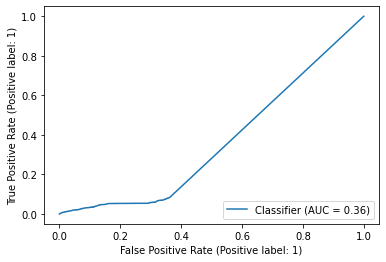

In [13]:
import evaluation
#metrics

print('SHINE')
evaluation.plot_roc_curve(np.array(arr_score_ID), np.array(arr_score_OOD))

print('mahalanobis')
evaluation.plot_roc_curve(scores_test_mahalanobis, scores_ood_mahalanobis)

In [14]:
arr_score_ID = np.array(arr_score_ID)
arr_score_OOD = np.array(arr_score_OOD)
precision_ood_shine, recall_ood_shine, f1_ood_shine = eval_ood.get_metrics(arr_score_ID.astype(bool), 
                                                                        arr_score_OOD.astype(bool))
precision_oms_shine, recall_oms_shine, f1_oms_shine = eval_oms.get_metrics(arr_score_ID.astype(bool), 
                                                                        arr_score_OOD.astype(bool))

print("SHINE")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_shine), "    ", "{:.4f}".format(recall_ood_shine), 
      " ", "{:.4f}".format(f1_ood_shine))
print("OMS:   ", "{:.4f}".format(precision_oms_shine), "    ", "{:.4f}".format(recall_oms_shine), 
      " ", "{:.4f}".format(f1_oms_shine))

SHINE
        Precision   Recall   F1
OOD:    0.9179      0.3633   0.5205
OMS:    0.9230      0.3566   0.5145


In [23]:
# looping through all monitored classes
monitored_classes = [i for i in range(10)]

# scores for each monitored class
arr_pred_test_per_class, arr_pred_ood_per_class = {}, {}

for monitored_class in monitored_classes:
    # we will then monitor the predicted class from the ML model
    predicted_ML = [monitored_class]*len(ood_X_test)
    
    arr_pred_test, arr_pred_ood = [], []
    
    for x, y_true, pred in zip(X_test, y_test, predicted_ML):
        if y_true == monitored_class:
            is_ood, shine_score = monitor_shine.predict(np.array([x]), pred)    
            arr_pred_test.append(is_ood)
            
    arr_pred_test_per_class.update({monitored_class: np.array(arr_pred_test)})

    for x, pred in zip(ood_X_test, predicted_ML):
        is_ood, shine_score = monitor_shine.predict(np.array([x]), pred)    
        arr_pred_ood.append(is_ood)
        
    arr_pred_ood_per_class.update({monitored_class: np.array(arr_pred_ood)})

In [11]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, matthews_corrcoef

# converting the labels from test dataset to the format 1 and 0
y_true = utils.convert_ood_labels(ood_y_test)
# printing balanced accuracy
acc = balanced_accuracy_score(y_true, arr_pred_ood)
print(acc)

0.999


In [24]:
#eval_oms = Evaluator("oms", is_novelty=(id_dataset!=ood_dataset))
eval_ood = Evaluator("ood", is_novelty=(id_dataset!=ood_dataset))

for monitored_class in monitored_classes:
    arr_pred_test, arr_pred_ood = arr_pred_test_per_class[monitored_class], arr_pred_ood_per_class[monitored_class]
    #eval_oms.fit_ground_truth(y_test, ood_y_test, arr_pred_test, arr_pred_ood)
    eval_ood.fit_ground_truth(y_test[y_test==monitored_class], ood_y_test, arr_pred_test, arr_pred_ood)

    precision_ood_shine, recall_ood_shine, f1_ood_shine = eval_ood.get_metrics(arr_pred_test.astype(bool), 
                                                                            arr_pred_ood.astype(bool))
    #precision_oms_shine, recall_oms_shine, f1_oms_shine = eval_oms.get_metrics(scores_test_shine, 
    #                                                                        scores_ood_shine)

    print("Shine when monitoring the class", monitored_class)
    print("       ", "Precision ", " Recall ", " F1")
    print("OOD:   ", "{:.4f}".format(precision_ood_shine), "    ", "{:.4f}".format(recall_ood_shine), 
          " ", "{:.4f}".format(f1_ood_shine))
    #print("OMS:   ", "{:.4f}".format(precision_oms_shine), "    ", "{:.4f}".format(recall_oms_shine), 
    #      " ", "{:.4f}".format(f1_oms_shine))

Shine when monitoring the class 0
        Precision   Recall   F1
OOD:    0.9766      0.9907   0.9836
Shine when monitoring the class 1
        Precision   Recall   F1
OOD:    0.9630      1.0000   0.9812
Shine when monitoring the class 2
        Precision   Recall   F1
OOD:    0.9630      1.0000   0.9812
Shine when monitoring the class 3
        Precision   Recall   F1
OOD:    0.9630      1.0000   0.9812
Shine when monitoring the class 4
        Precision   Recall   F1
OOD:    0.9811      0.9993   0.9901
Shine when monitoring the class 5
        Precision   Recall   F1
OOD:    0.9780      0.9977   0.9878
Shine when monitoring the class 6
        Precision   Recall   F1
OOD:    0.9630      1.0000   0.9812
Shine when monitoring the class 7
        Precision   Recall   F1
OOD:    0.9784      0.9996   0.9889
Shine when monitoring the class 8
        Precision   Recall   F1
OOD:    0.9630      1.0000   0.9812
Shine when monitoring the class 9
        Precision   Recall   F1
OOD:    0.9630  

Shine
        Precision   Recall   F1
OOD:    0.9115      0.9990   0.9532


In [19]:
monitor_oob = OutsideTheBoxMonitor(n_clusters=10)
monitor_oob.fit(features_train[id_layer_monitored], lab_train)

scores_oob_test = monitor_oob.predict(features_test[id_layer_monitored], pred_test)
scores_oob_ood = monitor_oob.predict(features_ood[id_layer_monitored], pred_ood)

precision_ood_oob, recall_ood_oob, f1_ood_oob = eval_ood.get_metrics(scores_oob_test, scores_oob_ood)
precision_oms_oob, recall_oms_oob, f1_oms_oob = eval_oms.get_metrics(scores_oob_test, scores_oob_ood)

print("Outside the box")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_oob), "    ", "{:.4f}".format(recall_ood_oob), 
      " ", "{:.4f}".format(f1_ood_oob))
print("OMS:   ", "{:.4f}".format(precision_oms_oob), "    ", "{:.4f}".format(recall_oms_oob), 
      " ", "{:.4f}".format(f1_oms_oob))

Outside the box
        Precision   Recall   F1
OOD:    0.7860      0.5971   0.6787
OMS:    0.4255      0.8458   0.5662


In [27]:
monitor_msp = MaxSoftmaxProbabilityMonitor()
monitor_msp.fit()

scores_test_msp = monitor_msp.predict(softmax_test) 
scores_ood_msp = monitor_msp.predict(softmax_ood) 

precision_ood_msp, recall_ood_msp, f1_ood_msp = eval_ood.get_metrics(scores_test_msp, scores_ood_msp,)
precision_oms_msp, recall_oms_msp, f1_oms_msp = eval_oms.get_metrics(scores_test_msp, scores_ood_msp,)

print("Max Softmax Probability")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_msp), "    ", "{:.4f}".format(recall_ood_msp), 
      " ", "{:.4f}".format(f1_ood_msp))
print("OMS:   ", "{:.4f}".format(precision_oms_msp), "    ", "{:.4f}".format(recall_oms_msp), 
      " ", "{:.4f}".format(f1_oms_msp))

getting optimal threshold...
getting optimal threshold...
Max Softmax Probability
        Precision   Recall   F1
OOD:    0.8986      0.9615   0.9290
OMS:    0.9199      0.9610   0.9400


In [21]:
monitor_react = ReActMonitor(quantile_value=0.99, mode="msp")
monitor_react.fit(feature_extractor, features_train[-1])

scores_test_react = monitor_react.predict(features_test[-1])
scores_ood_react = monitor_react.predict(features_ood[-1])

precision_ood_react_msp, recall_ood_react_msp, f1_ood_react_msp = eval_ood.get_metrics(scores_test_react, 
                                                                                       scores_ood_react)
precision_oms_react_msp, recall_oms_react_msp, f1_oms_react_msp = eval_oms.get_metrics(scores_test_react, 
                                                                                       scores_ood_react)

print("ReAct MSP")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_react_msp), "    ", "{:.4f}".format(recall_ood_react_msp), 
      " ", "{:.4f}".format(f1_ood_react_msp))
print("OMS:   ", "{:.4f}".format(precision_oms_react_msp), "    ", "{:.4f}".format(recall_oms_react_msp), 
      " ", "{:.4f}".format(f1_oms_react_msp))

ReAct MSP
        Precision   Recall   F1
OOD:    0.6015      0.7833   0.6804
OMS:    0.6878      0.8390   0.7559


In [22]:
monitor_maxlogits = MaxLogitMonitor()
monitor_maxlogits.fit()

scores_test_maxlogits = monitor_maxlogits.predict(logits_test) 
scores_ood_maxlogits = monitor_maxlogits.predict(logits_ood) 

precision_ood, recall_ood, f1_ood = eval_ood.get_metrics(scores_test_maxlogits, scores_ood_maxlogits)
precision_oms, recall_oms, f1_oms = eval_oms.get_metrics(scores_test_maxlogits, scores_ood_maxlogits)

print("Max Logit")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood), "    ", "{:.4f}".format(recall_ood), " ", "{:.4f}".format(f1_ood))
print("OMS:   ", "{:.4f}".format(precision_oms), "    ", "{:.4f}".format(recall_oms), " ", "{:.4f}".format(f1_oms))

Max Logit
        Precision   Recall   F1
OOD:    0.6220      0.7450   0.6780
OMS:    0.6982      0.8156   0.7523


In [23]:
T = 1

monitor_energy = EnergyMonitor(temperature=T)
monitor_energy.fit()

scores_test_energy = monitor_energy.predict(logits_test)
scores_ood_energy = monitor_energy.predict(logits_ood)

precision_ood_energy, recall_ood_energy, f1_ood_energy = eval_ood.get_metrics(scores_test_energy, scores_ood_energy)
precision_oms_energy, recall_oms_energy, f1_oms_energy = eval_oms.get_metrics(scores_test_energy, scores_ood_energy)

print("Energy")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_energy), "    ", "{:.4f}".format(recall_ood_energy), 
      " ", "{:.4f}".format(f1_ood_energy))
print("OMS:   ", "{:.4f}".format(precision_oms_energy), "    ", "{:.4f}".format(recall_oms_energy), 
      " ", "{:.4f}".format(f1_oms_energy))

Energy
        Precision   Recall   F1
OOD:    0.6219      0.7451   0.6780
OMS:    0.7000      0.8133   0.7524


In [24]:
monitor_react = ReActMonitor(quantile_value=0.99)
monitor_react.fit(feature_extractor, features_train[-1])

scores_test_react = monitor_react.predict(features_test[-1])
scores_ood_react = monitor_react.predict(features_ood[-1])

precision_ood_react_ene, recall_ood_react_ene, f1_ood_react_ene = eval_ood.get_metrics(scores_test_react, 
                                                                                       scores_ood_react)
precision_oms_react_ene, recall_oms_react_ene, f1_oms_react_ene = eval_oms.get_metrics(scores_test_react, 
                                                                                       scores_ood_react)

print("ReAct Energy")
print("       ", "Precision ", " Recall ", " F1")
print("OOD:   ", "{:.4f}".format(precision_ood_react_ene), "    ", "{:.4f}".format(recall_ood_react_ene), 
      " ", "{:.4f}".format(f1_ood_react_ene))
print("OMS:   ", "{:.4f}".format(precision_oms_react_ene), "    ", "{:.4f}".format(recall_oms_react_ene), 
      " ", "{:.4f}".format(f1_oms_react_ene))

ReAct Energy
        Precision   Recall   F1
OOD:    0.6059      0.7678   0.6773
OMS:    0.7028      0.8208   0.7572
